In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-13 18:00:15.158357: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-13 18:00:15.158439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-13 18:00:15.158445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "funnel")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.3
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.sigma = 1.1
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)
config.trainer.lr_sch_base_dec = 0.95 # For funnel
config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 6000
config.trainer.learning_rate = 1 * 10**(-5)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f1c4251f490>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f1c4251f640>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 5.09919548034668)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 5.098504066467285)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 5.211390495300293)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 5.117226600646973)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 5.2726263999938965)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 5.1528167724609375)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 5.151192665100098)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 5.1555986404418945)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 5.318872451782227)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 5.219282150268555)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 5.138143539428711)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 5.129854679107666)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 5.149849891662598)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 5.104379177093506)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 5.181883811950684)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 5.107566833496094)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 5.222733020782471)
('epo

('epoch: %s %s  loss: %s', 138, 'TRAIN', 5.16374397277832)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 5.0287981033325195)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 4.951625347137451)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 5.059063911437988)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 5.072234153747559)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 5.042821407318115)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 5.141812801361084)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 5.126509189605713)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 5.1725592613220215)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 5.043665885925293)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 5.118795394897461)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 5.021162509918213)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 5.127475738525391)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 4.9927659034729)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 4.9934306144714355)
('epoch: %s %s  loss: %s', 153, 'TRAIN', 5.032968997955322)
('epoch: %s %s  loss: %s', 154, 'TRAIN',

('epoch: %s %s  loss: %s', 275, 'TRAIN', 4.82309103012085)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 4.815701484680176)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 4.904732704162598)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 4.879591941833496)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 4.888968467712402)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 4.917463302612305)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 4.883553981781006)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 4.900671482086182)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 4.977034568786621)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 4.986557960510254)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 4.851820945739746)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 5.025120258331299)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 4.940390110015869)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 4.887343883514404)
('epoch: %s %s  loss: %s', 289, 'TRAIN', 4.980255126953125)
('epoch: %s %s  loss: %s', 290, 'TRAIN', 4.920253753662109)
('epoch: %s %s  loss: %s', 291, 'TRAIN', 

('epoch: %s %s  loss: %s', 412, 'TRAIN', 4.817658424377441)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 4.838594913482666)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 4.808704853057861)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 4.803812503814697)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 4.764373302459717)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 4.7315449714660645)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 4.803373336791992)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 4.626055717468262)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 4.637169361114502)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 4.78582239151001)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 4.90643835067749)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 4.70614767074585)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 4.7984619140625)
('epoch: %s %s  loss: %s', 425, 'TRAIN', 4.724254608154297)
('epoch: %s %s  loss: %s', 426, 'TRAIN', 4.680662155151367)
('epoch: %s %s  loss: %s', 427, 'TRAIN', 4.762662410736084)
('epoch: %s %s  loss: %s', 428, 'TRAIN', 4.7

('epoch: %s %s  loss: %s', 549, 'TRAIN', 4.569593906402588)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 4.599632740020752)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 4.4904866218566895)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 4.641340732574463)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 4.60939884185791)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 4.691308498382568)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 4.6201934814453125)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 4.55936336517334)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 4.563994884490967)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 4.47201681137085)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 4.695076942443848)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 4.699153423309326)
('epoch: %s %s  loss: %s', 561, 'TRAIN', 4.595746040344238)
('epoch: %s %s  loss: %s', 562, 'TRAIN', 4.5774760246276855)
('epoch: %s %s  loss: %s', 563, 'TRAIN', 4.587100982666016)
('epoch: %s %s  loss: %s', 564, 'TRAIN', 4.514113426208496)
('epoch: %s %s  loss: %s', 565, 'TRAIN',

('epoch: %s %s  loss: %s', 686, 'TRAIN', 4.5544304847717285)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 4.420957088470459)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 4.440736770629883)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 4.4611496925354)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 4.443921089172363)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 4.5786662101745605)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 4.45556640625)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 4.423128128051758)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 4.447606086730957)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 4.4348907470703125)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 4.520792007446289)
('epoch: %s %s  loss: %s', 697, 'TRAIN', 4.445933818817139)
('epoch: %s %s  loss: %s', 698, 'TRAIN', 4.551285743713379)
('epoch: %s %s  loss: %s', 699, 'TRAIN', 4.482572555541992)
('epoch: %s %s  loss: %s', 700, 'TRAIN', 4.4343581199646)
('epoch: %s %s  loss: %s', 701, 'TRAIN', 4.46124267578125)
('epoch: %s %s  loss: %s', 702, 'TRAIN', 4.591

('epoch: %s %s  loss: %s', 823, 'TRAIN', 4.422945499420166)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 4.509599208831787)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 4.379164695739746)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 4.3262715339660645)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 4.546905517578125)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 4.435430526733398)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 4.471218109130859)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 4.4933342933654785)
('epoch: %s %s  loss: %s', 831, 'TRAIN', 4.341302394866943)
('epoch: %s %s  loss: %s', 832, 'TRAIN', 4.333037853240967)
('epoch: %s %s  loss: %s', 833, 'TRAIN', 4.382083892822266)
('epoch: %s %s  loss: %s', 834, 'TRAIN', 4.330896854400635)
('epoch: %s %s  loss: %s', 835, 'TRAIN', 4.486933708190918)
('epoch: %s %s  loss: %s', 836, 'TRAIN', 4.430753707885742)
('epoch: %s %s  loss: %s', 837, 'TRAIN', 4.502701282501221)
('epoch: %s %s  loss: %s', 838, 'TRAIN', 4.507629871368408)
('epoch: %s %s  loss: %s', 839, 'TRAIN

('epoch: %s %s  loss: %s', 960, 'TRAIN', 4.50046968460083)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 4.369018077850342)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 4.284008026123047)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 4.451756954193115)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 4.464447975158691)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 4.469883918762207)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 4.352193355560303)
('epoch: %s %s  loss: %s', 967, 'TRAIN', 4.399633884429932)
('epoch: %s %s  loss: %s', 968, 'TRAIN', 4.383371353149414)
('epoch: %s %s  loss: %s', 969, 'TRAIN', 4.2994866371154785)
('epoch: %s %s  loss: %s', 970, 'TRAIN', 4.274997234344482)
('epoch: %s %s  loss: %s', 971, 'TRAIN', 4.351672172546387)
('epoch: %s %s  loss: %s', 972, 'TRAIN', 4.366883277893066)
('epoch: %s %s  loss: %s', 973, 'TRAIN', 4.426680088043213)
('epoch: %s %s  loss: %s', 974, 'TRAIN', 4.291439533233643)
('epoch: %s %s  loss: %s', 975, 'TRAIN', 4.240651607513428)
('epoch: %s %s  loss: %s', 976, 'TRAIN',

('epoch: %s %s  loss: %s', 1096, 'TRAIN', 4.2062811851501465)
('epoch: %s %s  loss: %s', 1097, 'TRAIN', 4.279331207275391)
('epoch: %s %s  loss: %s', 1098, 'TRAIN', 4.397045612335205)
('epoch: %s %s  loss: %s', 1099, 'TRAIN', 4.2631425857543945)
('epoch: %s %s  loss: %s', 1100, 'TRAIN', 4.338251113891602)
('epoch: %s %s  loss: %s', 1101, 'TRAIN', 4.312774658203125)
('epoch: %s %s  loss: %s', 1102, 'TRAIN', 4.26771879196167)
('epoch: %s %s  loss: %s', 1103, 'TRAIN', 4.349417209625244)
('epoch: %s %s  loss: %s', 1104, 'TRAIN', 4.30987024307251)
('epoch: %s %s  loss: %s', 1105, 'TRAIN', 4.344052314758301)
('epoch: %s %s  loss: %s', 1106, 'TRAIN', 4.375927448272705)
('epoch: %s %s  loss: %s', 1107, 'TRAIN', 4.227405548095703)
('epoch: %s %s  loss: %s', 1108, 'TRAIN', 4.3881916999816895)
('epoch: %s %s  loss: %s', 1109, 'TRAIN', 4.294338226318359)
('epoch: %s %s  loss: %s', 1110, 'TRAIN', 4.337794303894043)
('epoch: %s %s  loss: %s', 1111, 'TRAIN', 4.375415802001953)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 1231, 'TRAIN', 4.369284152984619)
('epoch: %s %s  loss: %s', 1232, 'TRAIN', 4.347754001617432)
('epoch: %s %s  loss: %s', 1233, 'TRAIN', 4.364202976226807)
('epoch: %s %s  loss: %s', 1234, 'TRAIN', 4.239776134490967)
('epoch: %s %s  loss: %s', 1235, 'TRAIN', 4.294703483581543)
('epoch: %s %s  loss: %s', 1236, 'TRAIN', 4.322122097015381)
('epoch: %s %s  loss: %s', 1237, 'TRAIN', 4.279592990875244)
('epoch: %s %s  loss: %s', 1238, 'TRAIN', 4.284721851348877)
('epoch: %s %s  loss: %s', 1239, 'TRAIN', 4.300961971282959)
('epoch: %s %s  loss: %s', 1240, 'TRAIN', 4.306178092956543)
('epoch: %s %s  loss: %s', 1241, 'TRAIN', 4.269963264465332)
('epoch: %s %s  loss: %s', 1242, 'TRAIN', 4.2333784103393555)
('epoch: %s %s  loss: %s', 1243, 'TRAIN', 4.274417400360107)
('epoch: %s %s  loss: %s', 1244, 'TRAIN', 4.236302852630615)
('epoch: %s %s  loss: %s', 1245, 'TRAIN', 4.2543158531188965)
('epoch: %s %s  loss: %s', 1246, 'TRAIN', 4.348381042480469)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 1366, 'TRAIN', 4.287674903869629)
('epoch: %s %s  loss: %s', 1367, 'TRAIN', 4.2944488525390625)
('epoch: %s %s  loss: %s', 1368, 'TRAIN', 4.274171352386475)
('epoch: %s %s  loss: %s', 1369, 'TRAIN', 4.3852434158325195)
('epoch: %s %s  loss: %s', 1370, 'TRAIN', 4.328344821929932)
('epoch: %s %s  loss: %s', 1371, 'TRAIN', 4.462695598602295)
('epoch: %s %s  loss: %s', 1372, 'TRAIN', 4.394692420959473)
('epoch: %s %s  loss: %s', 1373, 'TRAIN', 4.173562526702881)
('epoch: %s %s  loss: %s', 1374, 'TRAIN', 4.256977558135986)
('epoch: %s %s  loss: %s', 1375, 'TRAIN', 4.323863983154297)
('epoch: %s %s  loss: %s', 1376, 'TRAIN', 4.309075355529785)
('epoch: %s %s  loss: %s', 1377, 'TRAIN', 4.278275966644287)
('epoch: %s %s  loss: %s', 1378, 'TRAIN', 4.332139015197754)
('epoch: %s %s  loss: %s', 1379, 'TRAIN', 4.413171291351318)
('epoch: %s %s  loss: %s', 1380, 'TRAIN', 4.354557037353516)
('epoch: %s %s  loss: %s', 1381, 'TRAIN', 4.188015937805176)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 1501, 'TRAIN', 4.2813801765441895)
('epoch: %s %s  loss: %s', 1502, 'TRAIN', 4.322624206542969)
('epoch: %s %s  loss: %s', 1503, 'TRAIN', 4.2701334953308105)
('epoch: %s %s  loss: %s', 1504, 'TRAIN', 4.283357620239258)
('epoch: %s %s  loss: %s', 1505, 'TRAIN', 4.313960075378418)
('epoch: %s %s  loss: %s', 1506, 'TRAIN', 4.35829496383667)
('epoch: %s %s  loss: %s', 1507, 'TRAIN', 4.321792125701904)
('epoch: %s %s  loss: %s', 1508, 'TRAIN', 4.283454895019531)
('epoch: %s %s  loss: %s', 1509, 'TRAIN', 4.358756065368652)
('epoch: %s %s  loss: %s', 1510, 'TRAIN', 4.257896423339844)
('epoch: %s %s  loss: %s', 1511, 'TRAIN', 4.33030891418457)
('epoch: %s %s  loss: %s', 1512, 'TRAIN', 4.131139278411865)
('epoch: %s %s  loss: %s', 1513, 'TRAIN', 4.374361515045166)
('epoch: %s %s  loss: %s', 1514, 'TRAIN', 4.217067241668701)
('epoch: %s %s  loss: %s', 1515, 'TRAIN', 4.298059463500977)
('epoch: %s %s  loss: %s', 1516, 'TRAIN', 4.418867588043213)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 1636, 'TRAIN', 4.317233562469482)
('epoch: %s %s  loss: %s', 1637, 'TRAIN', 4.3181562423706055)
('epoch: %s %s  loss: %s', 1638, 'TRAIN', 4.3322062492370605)
('epoch: %s %s  loss: %s', 1639, 'TRAIN', 4.324668884277344)
('epoch: %s %s  loss: %s', 1640, 'TRAIN', 4.3283562660217285)
('epoch: %s %s  loss: %s', 1641, 'TRAIN', 4.234063625335693)
('epoch: %s %s  loss: %s', 1642, 'TRAIN', 4.298684120178223)
('epoch: %s %s  loss: %s', 1643, 'TRAIN', 4.205782890319824)
('epoch: %s %s  loss: %s', 1644, 'TRAIN', 4.300412178039551)
('epoch: %s %s  loss: %s', 1645, 'TRAIN', 4.272729873657227)
('epoch: %s %s  loss: %s', 1646, 'TRAIN', 4.340647220611572)
('epoch: %s %s  loss: %s', 1647, 'TRAIN', 4.324407577514648)
('epoch: %s %s  loss: %s', 1648, 'TRAIN', 4.224294185638428)
('epoch: %s %s  loss: %s', 1649, 'TRAIN', 4.346259117126465)
('epoch: %s %s  loss: %s', 1650, 'TRAIN', 4.27051305770874)
('epoch: %s %s  loss: %s', 1651, 'TRAIN', 4.355547904968262)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 1771, 'TRAIN', 4.265177249908447)
('epoch: %s %s  loss: %s', 1772, 'TRAIN', 4.260566711425781)
('epoch: %s %s  loss: %s', 1773, 'TRAIN', 4.3107686042785645)
('epoch: %s %s  loss: %s', 1774, 'TRAIN', 4.254723072052002)
('epoch: %s %s  loss: %s', 1775, 'TRAIN', 4.1536359786987305)
('epoch: %s %s  loss: %s', 1776, 'TRAIN', 4.264549255371094)
('epoch: %s %s  loss: %s', 1777, 'TRAIN', 4.276115894317627)
('epoch: %s %s  loss: %s', 1778, 'TRAIN', 4.351017475128174)
('epoch: %s %s  loss: %s', 1779, 'TRAIN', 4.2893757820129395)
('epoch: %s %s  loss: %s', 1780, 'TRAIN', 4.218327522277832)
('epoch: %s %s  loss: %s', 1781, 'TRAIN', 4.314352512359619)
('epoch: %s %s  loss: %s', 1782, 'TRAIN', 4.225513458251953)
('epoch: %s %s  loss: %s', 1783, 'TRAIN', 4.327261924743652)
('epoch: %s %s  loss: %s', 1784, 'TRAIN', 4.336872100830078)
('epoch: %s %s  loss: %s', 1785, 'TRAIN', 4.279305458068848)
('epoch: %s %s  loss: %s', 1786, 'TRAIN', 4.285894393920898)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 1906, 'TRAIN', 4.265953540802002)
('epoch: %s %s  loss: %s', 1907, 'TRAIN', 4.445624351501465)
('epoch: %s %s  loss: %s', 1908, 'TRAIN', 4.1841583251953125)
('epoch: %s %s  loss: %s', 1909, 'TRAIN', 4.3447346687316895)
('epoch: %s %s  loss: %s', 1910, 'TRAIN', 4.217670440673828)
('epoch: %s %s  loss: %s', 1911, 'TRAIN', 4.285409450531006)
('epoch: %s %s  loss: %s', 1912, 'TRAIN', 4.306078910827637)
('epoch: %s %s  loss: %s', 1913, 'TRAIN', 4.290945529937744)
('epoch: %s %s  loss: %s', 1914, 'TRAIN', 4.183267593383789)
('epoch: %s %s  loss: %s', 1915, 'TRAIN', 4.225200176239014)
('epoch: %s %s  loss: %s', 1916, 'TRAIN', 4.356044769287109)
('epoch: %s %s  loss: %s', 1917, 'TRAIN', 4.22145938873291)
('epoch: %s %s  loss: %s', 1918, 'TRAIN', 4.226073265075684)
('epoch: %s %s  loss: %s', 1919, 'TRAIN', 4.306211948394775)
('epoch: %s %s  loss: %s', 1920, 'TRAIN', 4.249685764312744)
('epoch: %s %s  loss: %s', 1921, 'TRAIN', 4.3352179527282715)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 2041, 'TRAIN', 4.302917957305908)
('epoch: %s %s  loss: %s', 2042, 'TRAIN', 4.349966049194336)
('epoch: %s %s  loss: %s', 2043, 'TRAIN', 4.356749057769775)
('epoch: %s %s  loss: %s', 2044, 'TRAIN', 4.388560771942139)
('epoch: %s %s  loss: %s', 2045, 'TRAIN', 4.200777053833008)
('epoch: %s %s  loss: %s', 2046, 'TRAIN', 4.233001232147217)
('epoch: %s %s  loss: %s', 2047, 'TRAIN', 4.38413667678833)
('epoch: %s %s  loss: %s', 2048, 'TRAIN', 4.446841239929199)
('epoch: %s %s  loss: %s', 2049, 'TRAIN', 4.350597381591797)
('epoch: %s %s  loss: %s', 2050, 'TRAIN', 4.2838873863220215)
('epoch: %s %s  loss: %s', 2051, 'TRAIN', 4.321608543395996)
('epoch: %s %s  loss: %s', 2052, 'TRAIN', 4.2950568199157715)
('epoch: %s %s  loss: %s', 2053, 'TRAIN', 4.347073078155518)
('epoch: %s %s  loss: %s', 2054, 'TRAIN', 4.269385814666748)
('epoch: %s %s  loss: %s', 2055, 'TRAIN', 4.252471923828125)
('epoch: %s %s  loss: %s', 2056, 'TRAIN', 4.270551681518555)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 2176, 'TRAIN', 4.305887699127197)
('epoch: %s %s  loss: %s', 2177, 'TRAIN', 4.357309818267822)
('epoch: %s %s  loss: %s', 2178, 'TRAIN', 4.416635513305664)
('epoch: %s %s  loss: %s', 2179, 'TRAIN', 4.3870744705200195)
('epoch: %s %s  loss: %s', 2180, 'TRAIN', 4.277226448059082)
('epoch: %s %s  loss: %s', 2181, 'TRAIN', 4.299912452697754)
('epoch: %s %s  loss: %s', 2182, 'TRAIN', 4.200366497039795)
('epoch: %s %s  loss: %s', 2183, 'TRAIN', 4.450023651123047)
('epoch: %s %s  loss: %s', 2184, 'TRAIN', 4.456552028656006)
('epoch: %s %s  loss: %s', 2185, 'TRAIN', 4.242988586425781)
('epoch: %s %s  loss: %s', 2186, 'TRAIN', 4.287214279174805)
('epoch: %s %s  loss: %s', 2187, 'TRAIN', 4.263387203216553)
('epoch: %s %s  loss: %s', 2188, 'TRAIN', 4.399627208709717)
('epoch: %s %s  loss: %s', 2189, 'TRAIN', 4.3078932762146)
('epoch: %s %s  loss: %s', 2190, 'TRAIN', 4.370229721069336)
('epoch: %s %s  loss: %s', 2191, 'TRAIN', 4.215762615203857)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 2311, 'TRAIN', 4.241828441619873)
('epoch: %s %s  loss: %s', 2312, 'TRAIN', 4.375669479370117)
('epoch: %s %s  loss: %s', 2313, 'TRAIN', 4.3157548904418945)
('epoch: %s %s  loss: %s', 2314, 'TRAIN', 4.24568510055542)
('epoch: %s %s  loss: %s', 2315, 'TRAIN', 4.328751087188721)
('epoch: %s %s  loss: %s', 2316, 'TRAIN', 4.3308587074279785)
('epoch: %s %s  loss: %s', 2317, 'TRAIN', 4.395308971405029)
('epoch: %s %s  loss: %s', 2318, 'TRAIN', 4.271145820617676)
('epoch: %s %s  loss: %s', 2319, 'TRAIN', 4.356966018676758)
('epoch: %s %s  loss: %s', 2320, 'TRAIN', 4.326695442199707)
('epoch: %s %s  loss: %s', 2321, 'TRAIN', 4.319885730743408)
('epoch: %s %s  loss: %s', 2322, 'TRAIN', 4.327725887298584)
('epoch: %s %s  loss: %s', 2323, 'TRAIN', 4.291236877441406)
('epoch: %s %s  loss: %s', 2324, 'TRAIN', 4.415419101715088)
('epoch: %s %s  loss: %s', 2325, 'TRAIN', 4.289443016052246)
('epoch: %s %s  loss: %s', 2326, 'TRAIN', 4.301674842834473)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 2446, 'TRAIN', 4.438309669494629)
('epoch: %s %s  loss: %s', 2447, 'TRAIN', 4.311023712158203)
('epoch: %s %s  loss: %s', 2448, 'TRAIN', 4.278806686401367)
('epoch: %s %s  loss: %s', 2449, 'TRAIN', 4.3662285804748535)
('epoch: %s %s  loss: %s', 2450, 'TRAIN', 4.36348295211792)
('epoch: %s %s  loss: %s', 2451, 'TRAIN', 4.243740558624268)
('epoch: %s %s  loss: %s', 2452, 'TRAIN', 4.31421422958374)
('epoch: %s %s  loss: %s', 2453, 'TRAIN', 4.294156074523926)
('epoch: %s %s  loss: %s', 2454, 'TRAIN', 4.23572301864624)
('epoch: %s %s  loss: %s', 2455, 'TRAIN', 4.320357799530029)
('epoch: %s %s  loss: %s', 2456, 'TRAIN', 4.2942891120910645)
('epoch: %s %s  loss: %s', 2457, 'TRAIN', 4.2592668533325195)
('epoch: %s %s  loss: %s', 2458, 'TRAIN', 4.351591110229492)
('epoch: %s %s  loss: %s', 2459, 'TRAIN', 4.255546569824219)
('epoch: %s %s  loss: %s', 2460, 'TRAIN', 4.439235687255859)
('epoch: %s %s  loss: %s', 2461, 'TRAIN', 4.385871887207031)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 2581, 'TRAIN', 4.4965434074401855)
('epoch: %s %s  loss: %s', 2582, 'TRAIN', 4.269151210784912)
('epoch: %s %s  loss: %s', 2583, 'TRAIN', 4.4318437576293945)
('epoch: %s %s  loss: %s', 2584, 'TRAIN', 4.377182960510254)
('epoch: %s %s  loss: %s', 2585, 'TRAIN', 4.3519673347473145)
('epoch: %s %s  loss: %s', 2586, 'TRAIN', 4.343312740325928)
('epoch: %s %s  loss: %s', 2587, 'TRAIN', 4.36531925201416)
('epoch: %s %s  loss: %s', 2588, 'TRAIN', 4.34250020980835)
('epoch: %s %s  loss: %s', 2589, 'TRAIN', 4.283670902252197)
('epoch: %s %s  loss: %s', 2590, 'TRAIN', 4.278987407684326)
('epoch: %s %s  loss: %s', 2591, 'TRAIN', 4.414255142211914)
('epoch: %s %s  loss: %s', 2592, 'TRAIN', 4.386197566986084)
('epoch: %s %s  loss: %s', 2593, 'TRAIN', 4.311241626739502)
('epoch: %s %s  loss: %s', 2594, 'TRAIN', 4.279162883758545)
('epoch: %s %s  loss: %s', 2595, 'TRAIN', 4.4567646980285645)
('epoch: %s %s  loss: %s', 2596, 'TRAIN', 4.398821830749512)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 2716, 'TRAIN', 4.327479839324951)
('epoch: %s %s  loss: %s', 2717, 'TRAIN', 4.354681968688965)
('epoch: %s %s  loss: %s', 2718, 'TRAIN', 4.297224044799805)
('epoch: %s %s  loss: %s', 2719, 'TRAIN', 4.464529514312744)
('epoch: %s %s  loss: %s', 2720, 'TRAIN', 4.303611755371094)
('epoch: %s %s  loss: %s', 2721, 'TRAIN', 4.262068748474121)
('epoch: %s %s  loss: %s', 2722, 'TRAIN', 4.391597747802734)
('epoch: %s %s  loss: %s', 2723, 'TRAIN', 4.281670093536377)
('epoch: %s %s  loss: %s', 2724, 'TRAIN', 4.216607570648193)
('epoch: %s %s  loss: %s', 2725, 'TRAIN', 4.3383469581604)
('epoch: %s %s  loss: %s', 2726, 'TRAIN', 4.4227118492126465)
('epoch: %s %s  loss: %s', 2727, 'TRAIN', 4.2865986824035645)
('epoch: %s %s  loss: %s', 2728, 'TRAIN', 4.4610419273376465)
('epoch: %s %s  loss: %s', 2729, 'TRAIN', 4.405494689941406)
('epoch: %s %s  loss: %s', 2730, 'TRAIN', 4.416567802429199)
('epoch: %s %s  loss: %s', 2731, 'TRAIN', 4.297749042510986)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 2851, 'TRAIN', 4.3980793952941895)
('epoch: %s %s  loss: %s', 2852, 'TRAIN', 4.26808500289917)
('epoch: %s %s  loss: %s', 2853, 'TRAIN', 4.264251232147217)
('epoch: %s %s  loss: %s', 2854, 'TRAIN', 4.334201335906982)
('epoch: %s %s  loss: %s', 2855, 'TRAIN', 4.307915687561035)
('epoch: %s %s  loss: %s', 2856, 'TRAIN', 4.346777439117432)
('epoch: %s %s  loss: %s', 2857, 'TRAIN', 4.424612045288086)
('epoch: %s %s  loss: %s', 2858, 'TRAIN', 4.445062637329102)
('epoch: %s %s  loss: %s', 2859, 'TRAIN', 4.343485355377197)
('epoch: %s %s  loss: %s', 2860, 'TRAIN', 4.353636741638184)
('epoch: %s %s  loss: %s', 2861, 'TRAIN', 4.344348907470703)
('epoch: %s %s  loss: %s', 2862, 'TRAIN', 4.427859306335449)
('epoch: %s %s  loss: %s', 2863, 'TRAIN', 4.340862274169922)
('epoch: %s %s  loss: %s', 2864, 'TRAIN', 4.279233932495117)
('epoch: %s %s  loss: %s', 2865, 'TRAIN', 4.316771507263184)
('epoch: %s %s  loss: %s', 2866, 'TRAIN', 4.395576477050781)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 2986, 'TRAIN', 4.490630149841309)
('epoch: %s %s  loss: %s', 2987, 'TRAIN', 4.327483654022217)
('epoch: %s %s  loss: %s', 2988, 'TRAIN', 4.350598335266113)
('epoch: %s %s  loss: %s', 2989, 'TRAIN', 4.381258010864258)
('epoch: %s %s  loss: %s', 2990, 'TRAIN', 4.340083122253418)
('epoch: %s %s  loss: %s', 2991, 'TRAIN', 4.256844997406006)
('epoch: %s %s  loss: %s', 2992, 'TRAIN', 4.42110013961792)
('epoch: %s %s  loss: %s', 2993, 'TRAIN', 4.4910478591918945)
('epoch: %s %s  loss: %s', 2994, 'TRAIN', 4.411401271820068)
('epoch: %s %s  loss: %s', 2995, 'TRAIN', 4.35589075088501)
('epoch: %s %s  loss: %s', 2996, 'TRAIN', 4.269805908203125)
('epoch: %s %s  loss: %s', 2997, 'TRAIN', 4.397782802581787)
('epoch: %s %s  loss: %s', 2998, 'TRAIN', 4.3285346031188965)
('epoch: %s %s  loss: %s', 2999, 'TRAIN', 4.3085784912109375)
('epoch: %s %s  loss: %s', 3000, 'TRAIN', 4.281711101531982)
('epoch: %s %s  loss: %s', 3001, 'TRAIN', 4.369515895843506)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 3121, 'TRAIN', 4.355205059051514)
('epoch: %s %s  loss: %s', 3122, 'TRAIN', 4.489124774932861)
('epoch: %s %s  loss: %s', 3123, 'TRAIN', 4.40424919128418)
('epoch: %s %s  loss: %s', 3124, 'TRAIN', 4.314803600311279)
('epoch: %s %s  loss: %s', 3125, 'TRAIN', 4.441580295562744)
('epoch: %s %s  loss: %s', 3126, 'TRAIN', 4.346568584442139)
('epoch: %s %s  loss: %s', 3127, 'TRAIN', 4.342162609100342)
('epoch: %s %s  loss: %s', 3128, 'TRAIN', 4.450066089630127)
('epoch: %s %s  loss: %s', 3129, 'TRAIN', 4.396412372589111)
('epoch: %s %s  loss: %s', 3130, 'TRAIN', 4.429704189300537)
('epoch: %s %s  loss: %s', 3131, 'TRAIN', 4.47221040725708)
('epoch: %s %s  loss: %s', 3132, 'TRAIN', 4.426100254058838)
('epoch: %s %s  loss: %s', 3133, 'TRAIN', 4.314650535583496)
('epoch: %s %s  loss: %s', 3134, 'TRAIN', 4.541159629821777)
('epoch: %s %s  loss: %s', 3135, 'TRAIN', 4.371784210205078)
('epoch: %s %s  loss: %s', 3136, 'TRAIN', 4.3060712814331055)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 3256, 'TRAIN', 4.398120403289795)
('epoch: %s %s  loss: %s', 3257, 'TRAIN', 4.3909406661987305)
('epoch: %s %s  loss: %s', 3258, 'TRAIN', 4.391000747680664)
('epoch: %s %s  loss: %s', 3259, 'TRAIN', 4.348134994506836)
('epoch: %s %s  loss: %s', 3260, 'TRAIN', 4.40065336227417)
('epoch: %s %s  loss: %s', 3261, 'TRAIN', 4.432314872741699)
('epoch: %s %s  loss: %s', 3262, 'TRAIN', 4.392877101898193)
('epoch: %s %s  loss: %s', 3263, 'TRAIN', 4.305034637451172)
('epoch: %s %s  loss: %s', 3264, 'TRAIN', 4.304615497589111)
('epoch: %s %s  loss: %s', 3265, 'TRAIN', 4.3314385414123535)
('epoch: %s %s  loss: %s', 3266, 'TRAIN', 4.425420761108398)
('epoch: %s %s  loss: %s', 3267, 'TRAIN', 4.400829792022705)
('epoch: %s %s  loss: %s', 3268, 'TRAIN', 4.275808811187744)
('epoch: %s %s  loss: %s', 3269, 'TRAIN', 4.396040916442871)
('epoch: %s %s  loss: %s', 3270, 'TRAIN', 4.424727916717529)
('epoch: %s %s  loss: %s', 3271, 'TRAIN', 4.540263652801514)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 3391, 'TRAIN', 4.346476078033447)
('epoch: %s %s  loss: %s', 3392, 'TRAIN', 4.464620113372803)
('epoch: %s %s  loss: %s', 3393, 'TRAIN', 4.4811553955078125)
('epoch: %s %s  loss: %s', 3394, 'TRAIN', 4.353104591369629)
('epoch: %s %s  loss: %s', 3395, 'TRAIN', 4.274986743927002)
('epoch: %s %s  loss: %s', 3396, 'TRAIN', 4.368227958679199)
('epoch: %s %s  loss: %s', 3397, 'TRAIN', 4.383862495422363)
('epoch: %s %s  loss: %s', 3398, 'TRAIN', 4.337899684906006)
('epoch: %s %s  loss: %s', 3399, 'TRAIN', 4.3743977546691895)
('epoch: %s %s  loss: %s', 3400, 'TRAIN', 4.317320823669434)
('epoch: %s %s  loss: %s', 3401, 'TRAIN', 4.358144760131836)
('epoch: %s %s  loss: %s', 3402, 'TRAIN', 4.327878952026367)
('epoch: %s %s  loss: %s', 3403, 'TRAIN', 4.474136829376221)
('epoch: %s %s  loss: %s', 3404, 'TRAIN', 4.389916896820068)
('epoch: %s %s  loss: %s', 3405, 'TRAIN', 4.407932758331299)
('epoch: %s %s  loss: %s', 3406, 'TRAIN', 4.2819013595581055)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 3526, 'TRAIN', 4.405302047729492)
('epoch: %s %s  loss: %s', 3527, 'TRAIN', 4.407184600830078)
('epoch: %s %s  loss: %s', 3528, 'TRAIN', 4.369507789611816)
('epoch: %s %s  loss: %s', 3529, 'TRAIN', 4.385578632354736)
('epoch: %s %s  loss: %s', 3530, 'TRAIN', 4.489988327026367)
('epoch: %s %s  loss: %s', 3531, 'TRAIN', 4.379907608032227)
('epoch: %s %s  loss: %s', 3532, 'TRAIN', 4.426993370056152)
('epoch: %s %s  loss: %s', 3533, 'TRAIN', 4.3579182624816895)
('epoch: %s %s  loss: %s', 3534, 'TRAIN', 4.384673118591309)
('epoch: %s %s  loss: %s', 3535, 'TRAIN', 4.422919750213623)
('epoch: %s %s  loss: %s', 3536, 'TRAIN', 4.404942989349365)
('epoch: %s %s  loss: %s', 3537, 'TRAIN', 4.346390247344971)
('epoch: %s %s  loss: %s', 3538, 'TRAIN', 4.337566375732422)
('epoch: %s %s  loss: %s', 3539, 'TRAIN', 4.293290138244629)
('epoch: %s %s  loss: %s', 3540, 'TRAIN', 4.247500419616699)
('epoch: %s %s  loss: %s', 3541, 'TRAIN', 4.3901214599609375)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 3661, 'TRAIN', 4.2875165939331055)
('epoch: %s %s  loss: %s', 3662, 'TRAIN', 4.40125036239624)
('epoch: %s %s  loss: %s', 3663, 'TRAIN', 4.350793361663818)
('epoch: %s %s  loss: %s', 3664, 'TRAIN', 4.235183238983154)
('epoch: %s %s  loss: %s', 3665, 'TRAIN', 4.369547367095947)
('epoch: %s %s  loss: %s', 3666, 'TRAIN', 4.367429733276367)
('epoch: %s %s  loss: %s', 3667, 'TRAIN', 4.47935152053833)
('epoch: %s %s  loss: %s', 3668, 'TRAIN', 4.452685356140137)
('epoch: %s %s  loss: %s', 3669, 'TRAIN', 4.300313949584961)
('epoch: %s %s  loss: %s', 3670, 'TRAIN', 4.27393102645874)
('epoch: %s %s  loss: %s', 3671, 'TRAIN', 4.238914489746094)
('epoch: %s %s  loss: %s', 3672, 'TRAIN', 4.403265953063965)
('epoch: %s %s  loss: %s', 3673, 'TRAIN', 4.450584411621094)
('epoch: %s %s  loss: %s', 3674, 'TRAIN', 4.446561813354492)
('epoch: %s %s  loss: %s', 3675, 'TRAIN', 4.449587345123291)
('epoch: %s %s  loss: %s', 3676, 'TRAIN', 4.2513604164123535)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 3796, 'TRAIN', 4.315150260925293)
('epoch: %s %s  loss: %s', 3797, 'TRAIN', 4.466441631317139)
('epoch: %s %s  loss: %s', 3798, 'TRAIN', 4.40494441986084)
('epoch: %s %s  loss: %s', 3799, 'TRAIN', 4.311703681945801)
('epoch: %s %s  loss: %s', 3800, 'TRAIN', 4.492708683013916)
('epoch: %s %s  loss: %s', 3801, 'TRAIN', 4.310850620269775)
('epoch: %s %s  loss: %s', 3802, 'TRAIN', 4.460897445678711)
('epoch: %s %s  loss: %s', 3803, 'TRAIN', 4.280872344970703)
('epoch: %s %s  loss: %s', 3804, 'TRAIN', 4.327791690826416)
('epoch: %s %s  loss: %s', 3805, 'TRAIN', 4.512746334075928)
('epoch: %s %s  loss: %s', 3806, 'TRAIN', 4.27834415435791)
('epoch: %s %s  loss: %s', 3807, 'TRAIN', 4.292455673217773)
('epoch: %s %s  loss: %s', 3808, 'TRAIN', 4.3522210121154785)
('epoch: %s %s  loss: %s', 3809, 'TRAIN', 4.401397228240967)
('epoch: %s %s  loss: %s', 3810, 'TRAIN', 4.23677396774292)
('epoch: %s %s  loss: %s', 3811, 'TRAIN', 4.339825630187988)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 3931, 'TRAIN', 4.395633697509766)
('epoch: %s %s  loss: %s', 3932, 'TRAIN', 4.333019733428955)
('epoch: %s %s  loss: %s', 3933, 'TRAIN', 4.335395336151123)
('epoch: %s %s  loss: %s', 3934, 'TRAIN', 4.556206226348877)
('epoch: %s %s  loss: %s', 3935, 'TRAIN', 4.452658176422119)
('epoch: %s %s  loss: %s', 3936, 'TRAIN', 4.415978908538818)
('epoch: %s %s  loss: %s', 3937, 'TRAIN', 4.536401271820068)
('epoch: %s %s  loss: %s', 3938, 'TRAIN', 4.420648097991943)
('epoch: %s %s  loss: %s', 3939, 'TRAIN', 4.429897308349609)
('epoch: %s %s  loss: %s', 3940, 'TRAIN', 4.406851291656494)
('epoch: %s %s  loss: %s', 3941, 'TRAIN', 4.198390007019043)
('epoch: %s %s  loss: %s', 3942, 'TRAIN', 4.425957202911377)
('epoch: %s %s  loss: %s', 3943, 'TRAIN', 4.444436073303223)
('epoch: %s %s  loss: %s', 3944, 'TRAIN', 4.330068588256836)
('epoch: %s %s  loss: %s', 3945, 'TRAIN', 4.319164752960205)
('epoch: %s %s  loss: %s', 3946, 'TRAIN', 4.401571273803711)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 4066, 'TRAIN', 4.358402729034424)
('epoch: %s %s  loss: %s', 4067, 'TRAIN', 4.405328273773193)
('epoch: %s %s  loss: %s', 4068, 'TRAIN', 4.510107517242432)
('epoch: %s %s  loss: %s', 4069, 'TRAIN', 4.38791036605835)
('epoch: %s %s  loss: %s', 4070, 'TRAIN', 4.262988567352295)
('epoch: %s %s  loss: %s', 4071, 'TRAIN', 4.441231727600098)
('epoch: %s %s  loss: %s', 4072, 'TRAIN', 4.376826286315918)
('epoch: %s %s  loss: %s', 4073, 'TRAIN', 4.317966461181641)
('epoch: %s %s  loss: %s', 4074, 'TRAIN', 4.277897834777832)
('epoch: %s %s  loss: %s', 4075, 'TRAIN', 4.289422988891602)
('epoch: %s %s  loss: %s', 4076, 'TRAIN', 4.304921627044678)
('epoch: %s %s  loss: %s', 4077, 'TRAIN', 4.444570541381836)
('epoch: %s %s  loss: %s', 4078, 'TRAIN', 4.436042308807373)
('epoch: %s %s  loss: %s', 4079, 'TRAIN', 4.287025451660156)
('epoch: %s %s  loss: %s', 4080, 'TRAIN', 4.308621883392334)
('epoch: %s %s  loss: %s', 4081, 'TRAIN', 4.261232852935791)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 4201, 'TRAIN', 4.424992561340332)
('epoch: %s %s  loss: %s', 4202, 'TRAIN', 4.446425914764404)
('epoch: %s %s  loss: %s', 4203, 'TRAIN', 4.353341102600098)
('epoch: %s %s  loss: %s', 4204, 'TRAIN', 4.315897464752197)
('epoch: %s %s  loss: %s', 4205, 'TRAIN', 4.361420154571533)
('epoch: %s %s  loss: %s', 4206, 'TRAIN', 4.4139838218688965)
('epoch: %s %s  loss: %s', 4207, 'TRAIN', 4.419021129608154)
('epoch: %s %s  loss: %s', 4208, 'TRAIN', 4.467680931091309)
('epoch: %s %s  loss: %s', 4209, 'TRAIN', 4.301299095153809)
('epoch: %s %s  loss: %s', 4210, 'TRAIN', 4.3944926261901855)
('epoch: %s %s  loss: %s', 4211, 'TRAIN', 4.427377223968506)
('epoch: %s %s  loss: %s', 4212, 'TRAIN', 4.492945194244385)
('epoch: %s %s  loss: %s', 4213, 'TRAIN', 4.364237308502197)
('epoch: %s %s  loss: %s', 4214, 'TRAIN', 4.417124271392822)
('epoch: %s %s  loss: %s', 4215, 'TRAIN', 4.5183491706848145)
('epoch: %s %s  loss: %s', 4216, 'TRAIN', 4.402554035186768)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 4336, 'TRAIN', 4.305548191070557)
('epoch: %s %s  loss: %s', 4337, 'TRAIN', 4.463618278503418)
('epoch: %s %s  loss: %s', 4338, 'TRAIN', 4.480904579162598)
('epoch: %s %s  loss: %s', 4339, 'TRAIN', 4.318741321563721)
('epoch: %s %s  loss: %s', 4340, 'TRAIN', 4.466198444366455)
('epoch: %s %s  loss: %s', 4341, 'TRAIN', 4.449613571166992)
('epoch: %s %s  loss: %s', 4342, 'TRAIN', 4.357786178588867)
('epoch: %s %s  loss: %s', 4343, 'TRAIN', 4.397310733795166)
('epoch: %s %s  loss: %s', 4344, 'TRAIN', 4.298644542694092)
('epoch: %s %s  loss: %s', 4345, 'TRAIN', 4.329355716705322)
('epoch: %s %s  loss: %s', 4346, 'TRAIN', 4.316843032836914)
('epoch: %s %s  loss: %s', 4347, 'TRAIN', 4.473105430603027)
('epoch: %s %s  loss: %s', 4348, 'TRAIN', 4.4445109367370605)
('epoch: %s %s  loss: %s', 4349, 'TRAIN', 4.395983695983887)
('epoch: %s %s  loss: %s', 4350, 'TRAIN', 4.368709564208984)
('epoch: %s %s  loss: %s', 4351, 'TRAIN', 4.293394088745117)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 4471, 'TRAIN', 4.383322238922119)
('epoch: %s %s  loss: %s', 4472, 'TRAIN', 4.509673118591309)
('epoch: %s %s  loss: %s', 4473, 'TRAIN', 4.422143936157227)
('epoch: %s %s  loss: %s', 4474, 'TRAIN', 4.49879789352417)
('epoch: %s %s  loss: %s', 4475, 'TRAIN', 4.227685928344727)
('epoch: %s %s  loss: %s', 4476, 'TRAIN', 4.290402889251709)
('epoch: %s %s  loss: %s', 4477, 'TRAIN', 4.401440620422363)
('epoch: %s %s  loss: %s', 4478, 'TRAIN', 4.357661724090576)
('epoch: %s %s  loss: %s', 4479, 'TRAIN', 4.500028610229492)
('epoch: %s %s  loss: %s', 4480, 'TRAIN', 4.353924751281738)
('epoch: %s %s  loss: %s', 4481, 'TRAIN', 4.2669358253479)
('epoch: %s %s  loss: %s', 4482, 'TRAIN', 4.393777370452881)
('epoch: %s %s  loss: %s', 4483, 'TRAIN', 4.374255180358887)
('epoch: %s %s  loss: %s', 4484, 'TRAIN', 4.4171142578125)
('epoch: %s %s  loss: %s', 4485, 'TRAIN', 4.369720935821533)
('epoch: %s %s  loss: %s', 4486, 'TRAIN', 4.449380874633789)
('epoch: %s %s  loss: %s', 44

('epoch: %s %s  loss: %s', 4606, 'TRAIN', 4.434351921081543)
('epoch: %s %s  loss: %s', 4607, 'TRAIN', 4.344760417938232)
('epoch: %s %s  loss: %s', 4608, 'TRAIN', 4.376924514770508)
('epoch: %s %s  loss: %s', 4609, 'TRAIN', 4.413740634918213)
('epoch: %s %s  loss: %s', 4610, 'TRAIN', 4.380360126495361)
('epoch: %s %s  loss: %s', 4611, 'TRAIN', 4.451690673828125)
('epoch: %s %s  loss: %s', 4612, 'TRAIN', 4.53751802444458)
('epoch: %s %s  loss: %s', 4613, 'TRAIN', 4.3574934005737305)
('epoch: %s %s  loss: %s', 4614, 'TRAIN', 4.393862724304199)
('epoch: %s %s  loss: %s', 4615, 'TRAIN', 4.330057621002197)
('epoch: %s %s  loss: %s', 4616, 'TRAIN', 4.353382110595703)
('epoch: %s %s  loss: %s', 4617, 'TRAIN', 4.458207130432129)
('epoch: %s %s  loss: %s', 4618, 'TRAIN', 4.476513862609863)
('epoch: %s %s  loss: %s', 4619, 'TRAIN', 4.347896099090576)
('epoch: %s %s  loss: %s', 4620, 'TRAIN', 4.408451557159424)
('epoch: %s %s  loss: %s', 4621, 'TRAIN', 4.430853843688965)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 4741, 'TRAIN', 4.383731365203857)
('epoch: %s %s  loss: %s', 4742, 'TRAIN', 4.359378337860107)
('epoch: %s %s  loss: %s', 4743, 'TRAIN', 4.411675930023193)
('epoch: %s %s  loss: %s', 4744, 'TRAIN', 4.203891754150391)
('epoch: %s %s  loss: %s', 4745, 'TRAIN', 4.454708576202393)
('epoch: %s %s  loss: %s', 4746, 'TRAIN', 4.407484531402588)
('epoch: %s %s  loss: %s', 4747, 'TRAIN', 4.411567687988281)
('epoch: %s %s  loss: %s', 4748, 'TRAIN', 4.467998027801514)
('epoch: %s %s  loss: %s', 4749, 'TRAIN', 4.396543502807617)
('epoch: %s %s  loss: %s', 4750, 'TRAIN', 4.437891483306885)
('epoch: %s %s  loss: %s', 4751, 'TRAIN', 4.3571367263793945)
('epoch: %s %s  loss: %s', 4752, 'TRAIN', 4.4224653244018555)
('epoch: %s %s  loss: %s', 4753, 'TRAIN', 4.482344627380371)
('epoch: %s %s  loss: %s', 4754, 'TRAIN', 4.418208599090576)
('epoch: %s %s  loss: %s', 4755, 'TRAIN', 4.449892997741699)
('epoch: %s %s  loss: %s', 4756, 'TRAIN', 4.259329795837402)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 4876, 'TRAIN', 4.283503532409668)
('epoch: %s %s  loss: %s', 4877, 'TRAIN', 4.418115615844727)
('epoch: %s %s  loss: %s', 4878, 'TRAIN', 4.4545979499816895)
('epoch: %s %s  loss: %s', 4879, 'TRAIN', 4.409799098968506)
('epoch: %s %s  loss: %s', 4880, 'TRAIN', 4.346173286437988)
('epoch: %s %s  loss: %s', 4881, 'TRAIN', 4.359941482543945)
('epoch: %s %s  loss: %s', 4882, 'TRAIN', 4.290713310241699)
('epoch: %s %s  loss: %s', 4883, 'TRAIN', 4.4767045974731445)
('epoch: %s %s  loss: %s', 4884, 'TRAIN', 4.370090961456299)
('epoch: %s %s  loss: %s', 4885, 'TRAIN', 4.435356616973877)
('epoch: %s %s  loss: %s', 4886, 'TRAIN', 4.443671703338623)
('epoch: %s %s  loss: %s', 4887, 'TRAIN', 4.324697494506836)
('epoch: %s %s  loss: %s', 4888, 'TRAIN', 4.392187118530273)
('epoch: %s %s  loss: %s', 4889, 'TRAIN', 4.560186862945557)
('epoch: %s %s  loss: %s', 4890, 'TRAIN', 4.440513610839844)
('epoch: %s %s  loss: %s', 4891, 'TRAIN', 4.3594183921813965)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 5011, 'TRAIN', 4.352945327758789)
('epoch: %s %s  loss: %s', 5012, 'TRAIN', 4.383089065551758)
('epoch: %s %s  loss: %s', 5013, 'TRAIN', 4.373504161834717)
('epoch: %s %s  loss: %s', 5014, 'TRAIN', 4.375277519226074)
('epoch: %s %s  loss: %s', 5015, 'TRAIN', 4.483617305755615)
('epoch: %s %s  loss: %s', 5016, 'TRAIN', 4.386651039123535)
('epoch: %s %s  loss: %s', 5017, 'TRAIN', 4.468638896942139)
('epoch: %s %s  loss: %s', 5018, 'TRAIN', 4.374908447265625)
('epoch: %s %s  loss: %s', 5019, 'TRAIN', 4.443819522857666)
('epoch: %s %s  loss: %s', 5020, 'TRAIN', 4.362636089324951)
('epoch: %s %s  loss: %s', 5021, 'TRAIN', 4.517265796661377)
('epoch: %s %s  loss: %s', 5022, 'TRAIN', 4.386904716491699)
('epoch: %s %s  loss: %s', 5023, 'TRAIN', 4.37511682510376)
('epoch: %s %s  loss: %s', 5024, 'TRAIN', 4.419275283813477)
('epoch: %s %s  loss: %s', 5025, 'TRAIN', 4.369831085205078)
('epoch: %s %s  loss: %s', 5026, 'TRAIN', 4.467783451080322)
('epoch: %s %s  loss: %s'

('epoch: %s %s  loss: %s', 5146, 'TRAIN', 4.308287143707275)
('epoch: %s %s  loss: %s', 5147, 'TRAIN', 4.382621765136719)
('epoch: %s %s  loss: %s', 5148, 'TRAIN', 4.354786396026611)
('epoch: %s %s  loss: %s', 5149, 'TRAIN', 4.4402971267700195)
('epoch: %s %s  loss: %s', 5150, 'TRAIN', 4.272891044616699)
('epoch: %s %s  loss: %s', 5151, 'TRAIN', 4.288389682769775)
('epoch: %s %s  loss: %s', 5152, 'TRAIN', 4.4108195304870605)
('epoch: %s %s  loss: %s', 5153, 'TRAIN', 4.321047306060791)
('epoch: %s %s  loss: %s', 5154, 'TRAIN', 4.2989277839660645)
('epoch: %s %s  loss: %s', 5155, 'TRAIN', 4.486572742462158)
('epoch: %s %s  loss: %s', 5156, 'TRAIN', 4.383568286895752)
('epoch: %s %s  loss: %s', 5157, 'TRAIN', 4.268842697143555)
('epoch: %s %s  loss: %s', 5158, 'TRAIN', 4.394835948944092)
('epoch: %s %s  loss: %s', 5159, 'TRAIN', 4.375287055969238)
('epoch: %s %s  loss: %s', 5160, 'TRAIN', 4.4110236167907715)
('epoch: %s %s  loss: %s', 5161, 'TRAIN', 4.450201511383057)
('epoch: %s %s  loss

('epoch: %s %s  loss: %s', 5280, 'TRAIN', 4.4743194580078125)
('epoch: %s %s  loss: %s', 5281, 'TRAIN', 4.295726776123047)
('epoch: %s %s  loss: %s', 5282, 'TRAIN', 4.357049465179443)
('epoch: %s %s  loss: %s', 5283, 'TRAIN', 4.366462230682373)
('epoch: %s %s  loss: %s', 5284, 'TRAIN', 4.323671817779541)
('epoch: %s %s  loss: %s', 5285, 'TRAIN', 4.369294166564941)
('epoch: %s %s  loss: %s', 5286, 'TRAIN', 4.390384197235107)
('epoch: %s %s  loss: %s', 5287, 'TRAIN', 4.400345802307129)
('epoch: %s %s  loss: %s', 5288, 'TRAIN', 4.308836936950684)
('epoch: %s %s  loss: %s', 5289, 'TRAIN', 4.360766410827637)
('epoch: %s %s  loss: %s', 5290, 'TRAIN', 4.3480000495910645)
('epoch: %s %s  loss: %s', 5291, 'TRAIN', 4.271483421325684)
('epoch: %s %s  loss: %s', 5292, 'TRAIN', 4.34044075012207)
('epoch: %s %s  loss: %s', 5293, 'TRAIN', 4.515794277191162)
('epoch: %s %s  loss: %s', 5294, 'TRAIN', 4.379055976867676)
('epoch: %s %s  loss: %s', 5295, 'TRAIN', 4.499673843383789)
('epoch: %s %s  loss: %

('epoch: %s %s  loss: %s', 5415, 'TRAIN', 4.334264755249023)
('epoch: %s %s  loss: %s', 5416, 'TRAIN', 4.562168598175049)
('epoch: %s %s  loss: %s', 5417, 'TRAIN', 4.370115756988525)
('epoch: %s %s  loss: %s', 5418, 'TRAIN', 4.411056041717529)
('epoch: %s %s  loss: %s', 5419, 'TRAIN', 4.350983142852783)
('epoch: %s %s  loss: %s', 5420, 'TRAIN', 4.391524791717529)
('epoch: %s %s  loss: %s', 5421, 'TRAIN', 4.482046604156494)
('epoch: %s %s  loss: %s', 5422, 'TRAIN', 4.40040922164917)
('epoch: %s %s  loss: %s', 5423, 'TRAIN', 4.3467278480529785)
('epoch: %s %s  loss: %s', 5424, 'TRAIN', 4.314782619476318)
('epoch: %s %s  loss: %s', 5425, 'TRAIN', 4.517326831817627)
('epoch: %s %s  loss: %s', 5426, 'TRAIN', 4.50310754776001)
('epoch: %s %s  loss: %s', 5427, 'TRAIN', 4.3382086753845215)
('epoch: %s %s  loss: %s', 5428, 'TRAIN', 4.314964294433594)
('epoch: %s %s  loss: %s', 5429, 'TRAIN', 4.405050754547119)
('epoch: %s %s  loss: %s', 5430, 'TRAIN', 4.391105651855469)
('epoch: %s %s  loss: %s

('epoch: %s %s  loss: %s', 5550, 'TRAIN', 4.369504928588867)
('epoch: %s %s  loss: %s', 5551, 'TRAIN', 4.215827465057373)
('epoch: %s %s  loss: %s', 5552, 'TRAIN', 4.397061824798584)
('epoch: %s %s  loss: %s', 5553, 'TRAIN', 4.435186862945557)
('epoch: %s %s  loss: %s', 5554, 'TRAIN', 4.471991062164307)
('epoch: %s %s  loss: %s', 5555, 'TRAIN', 4.377238750457764)
('epoch: %s %s  loss: %s', 5556, 'TRAIN', 4.330605983734131)
('epoch: %s %s  loss: %s', 5557, 'TRAIN', 4.474159240722656)
('epoch: %s %s  loss: %s', 5558, 'TRAIN', 4.487575531005859)
('epoch: %s %s  loss: %s', 5559, 'TRAIN', 4.460356712341309)
('epoch: %s %s  loss: %s', 5560, 'TRAIN', 4.345276355743408)
('epoch: %s %s  loss: %s', 5561, 'TRAIN', 4.352141857147217)
('epoch: %s %s  loss: %s', 5562, 'TRAIN', 4.366881370544434)
('epoch: %s %s  loss: %s', 5563, 'TRAIN', 4.43089485168457)
('epoch: %s %s  loss: %s', 5564, 'TRAIN', 4.44057035446167)
('epoch: %s %s  loss: %s', 5565, 'TRAIN', 4.385247230529785)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 5685, 'TRAIN', 4.4485297203063965)
('epoch: %s %s  loss: %s', 5686, 'TRAIN', 4.48910665512085)
('epoch: %s %s  loss: %s', 5687, 'TRAIN', 4.466663360595703)
('epoch: %s %s  loss: %s', 5688, 'TRAIN', 4.458263874053955)
('epoch: %s %s  loss: %s', 5689, 'TRAIN', 4.413600444793701)
('epoch: %s %s  loss: %s', 5690, 'TRAIN', 4.403801918029785)
('epoch: %s %s  loss: %s', 5691, 'TRAIN', 4.416119575500488)
('epoch: %s %s  loss: %s', 5692, 'TRAIN', 4.3816657066345215)
('epoch: %s %s  loss: %s', 5693, 'TRAIN', 4.385814666748047)
('epoch: %s %s  loss: %s', 5694, 'TRAIN', 4.487926483154297)
('epoch: %s %s  loss: %s', 5695, 'TRAIN', 4.382287979125977)
('epoch: %s %s  loss: %s', 5696, 'TRAIN', 4.395680904388428)
('epoch: %s %s  loss: %s', 5697, 'TRAIN', 4.4036760330200195)
('epoch: %s %s  loss: %s', 5698, 'TRAIN', 4.356135368347168)
('epoch: %s %s  loss: %s', 5699, 'TRAIN', 4.444317817687988)
('epoch: %s %s  loss: %s', 5700, 'TRAIN', 4.463127613067627)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 5820, 'TRAIN', 4.349606990814209)
('epoch: %s %s  loss: %s', 5821, 'TRAIN', 4.417266845703125)
('epoch: %s %s  loss: %s', 5822, 'TRAIN', 4.530827522277832)
('epoch: %s %s  loss: %s', 5823, 'TRAIN', 4.4025373458862305)
('epoch: %s %s  loss: %s', 5824, 'TRAIN', 4.466378211975098)
('epoch: %s %s  loss: %s', 5825, 'TRAIN', 4.326203346252441)
('epoch: %s %s  loss: %s', 5826, 'TRAIN', 4.39364767074585)
('epoch: %s %s  loss: %s', 5827, 'TRAIN', 4.427979469299316)
('epoch: %s %s  loss: %s', 5828, 'TRAIN', 4.386722087860107)
('epoch: %s %s  loss: %s', 5829, 'TRAIN', 4.41748571395874)
('epoch: %s %s  loss: %s', 5830, 'TRAIN', 4.319800853729248)
('epoch: %s %s  loss: %s', 5831, 'TRAIN', 4.389309406280518)
('epoch: %s %s  loss: %s', 5832, 'TRAIN', 4.500758647918701)
('epoch: %s %s  loss: %s', 5833, 'TRAIN', 4.368036270141602)
('epoch: %s %s  loss: %s', 5834, 'TRAIN', 4.43361759185791)
('epoch: %s %s  loss: %s', 5835, 'TRAIN', 4.468803882598877)
('epoch: %s %s  loss: %s',

('epoch: %s %s  loss: %s', 5955, 'TRAIN', 4.354161739349365)
('epoch: %s %s  loss: %s', 5956, 'TRAIN', 4.3817973136901855)
('epoch: %s %s  loss: %s', 5957, 'TRAIN', 4.408884048461914)
('epoch: %s %s  loss: %s', 5958, 'TRAIN', 4.372243404388428)
('epoch: %s %s  loss: %s', 5959, 'TRAIN', 4.392494201660156)
('epoch: %s %s  loss: %s', 5960, 'TRAIN', 4.292750358581543)
('epoch: %s %s  loss: %s', 5961, 'TRAIN', 4.353039264678955)
('epoch: %s %s  loss: %s', 5962, 'TRAIN', 4.350676536560059)
('epoch: %s %s  loss: %s', 5963, 'TRAIN', 4.44230318069458)
('epoch: %s %s  loss: %s', 5964, 'TRAIN', 4.482662200927734)
('epoch: %s %s  loss: %s', 5965, 'TRAIN', 4.649730205535889)
('epoch: %s %s  loss: %s', 5966, 'TRAIN', 4.53596305847168)
('epoch: %s %s  loss: %s', 5967, 'TRAIN', 4.481290340423584)
('epoch: %s %s  loss: %s', 5968, 'TRAIN', 4.410775661468506)
('epoch: %s %s  loss: %s', 5969, 'TRAIN', 4.479833602905273)
('epoch: %s %s  loss: %s', 5970, 'TRAIN', 4.323195457458496)
('epoch: %s %s  loss: %s'

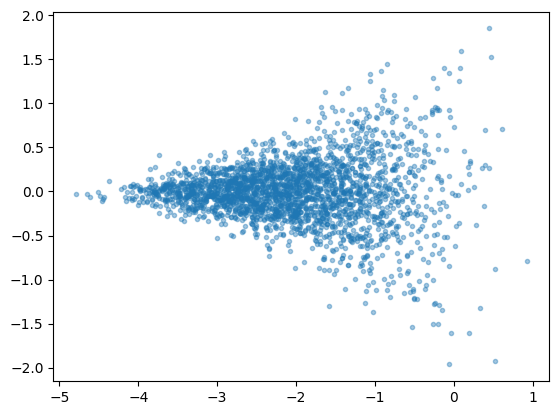

In [7]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

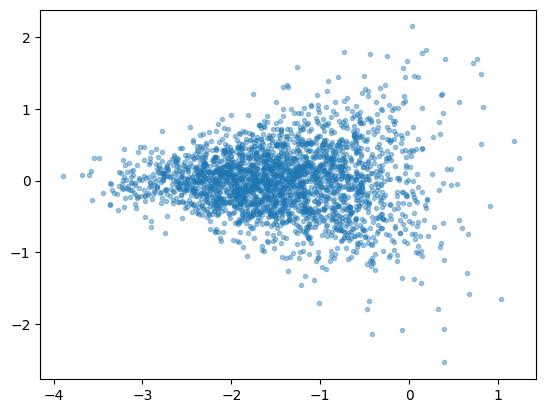

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [9]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(0.671329, dtype=float32)

In [10]:
results_dict["is_eval"]

[0.4702577590942383,
 0.6208620071411133,
 0.7154941558837891,
 0.2706789970397949,
 0.26471710205078125,
 0.4958062171936035,
 0.7410440444946289,
 1.1518287658691406,
 1.0859794616699219,
 1.247086524963379,
 0.029043197631835938,
 0.7829828262329102,
 0.5738749504089355,
 0.8167223930358887,
 0.8145627975463867,
 0.939824104309082,
 0.8068943023681641,
 1.1286940574645996,
 0.5831432342529297,
 -0.6642875671386719,
 0.8705668449401855,
 0.8369259834289551,
 0.9586715698242188,
 0.7526946067810059,
 0.70037841796875,
 0.8270478248596191,
 0.5459976196289062,
 0.4468250274658203,
 0.6198196411132812,
 0.7057313919067383]

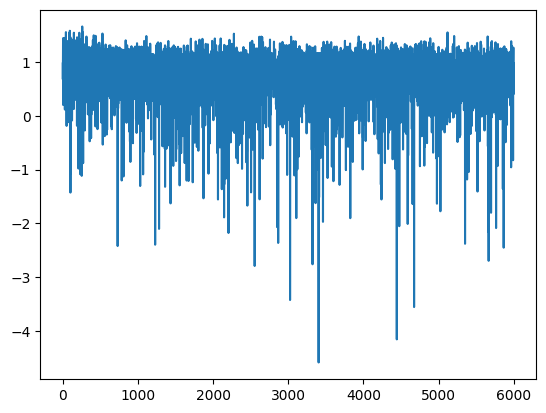

In [11]:
plt.plot(results_dict["is"])

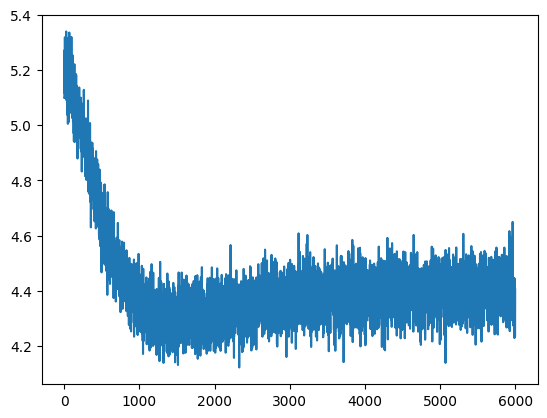

In [12]:
plt.plot(results_dict["elbo"])

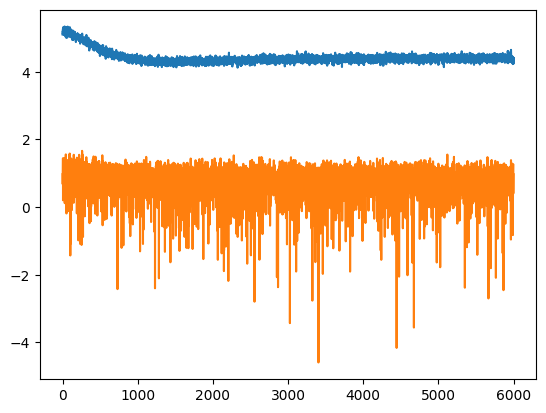

In [13]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])